In [61]:
import numpy as np
from numpy import mean, std, dstack
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
import keras
from keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, GlobalAveragePooling1D, GRU
from tensorflow.keras.layers import Dropout, BatchNormalization, Flatten, Add, Reshape
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras import optimizers

import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [62]:
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = dstack(loaded)
    return loaded
 
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + 'HAR/')
    testX, testy = load_dataset_group('test', prefix + 'HAR/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [63]:
trainX, trainy, testX, testy = load_dataset('data/')

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [64]:
batch_size = 32
validation_split = 0.2

In [65]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(GRU(64, input_shape=(n_timesteps,n_features), return_sequences=True))
model.add(GRU(32, return_sequences=True))

model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(128,32)))
model.add(Conv1D(filters=8, kernel_size=3))  
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(GRU(8))
model.add(Dropout(0.3))

model.add(Dense(n_outputs, activation='softmax'))

In [66]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_53 (GRU)                (None, 128, 64)           14400     
                                                                 
 gru_54 (GRU)                (None, 128, 32)           9408      
                                                                 
 conv1d_24 (Conv1D)          (None, 126, 16)           1552      
                                                                 
 conv1d_25 (Conv1D)          (None, 124, 8)            392       
                                                                 
 batch_normalization_10 (Ba  (None, 124, 8)            32        
 tchNormalization)                                               
                                                                 
 activation_9 (Activation)   (None, 124, 8)            0         
                                                     

In [67]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
train_epochs = 50
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/50
184/184 [==============================] - 54s 228ms/step - loss: 1.4095 - accuracy: 0.4965 - val_loss: 1.2779 - val_accuracy: 0.6533
Epoch 2/50
184/184 [==============================] - 38s 204ms/step - loss: 0.9219 - accuracy: 0.6898 - val_loss: 0.7382 - val_accuracy: 0.7811
Epoch 3/50
184/184 [==============================] - 37s 199ms/step - loss: 0.6520 - accuracy: 0.7963 - val_loss: 0.6294 - val_accuracy: 0.8552
Epoch 4/50
184/184 [==============================] - 36s 194ms/step - loss: 0.4425 - accuracy: 0.8873 - val_loss: 0.3987 - val_accuracy: 0.8980
Epoch 5/50
184/184 [==============================] - 39s 212ms/step - loss: 0.3355 - accuracy: 0.9146 - val_loss: 0.2892 - val_accuracy: 0.9075
Epoch 6/50
184/184 [==============================] - 37s 202ms/step - loss: 0.3015 - accuracy: 0.9208 - val_loss: 0.2939 - val_accuracy: 0.9116
Epoch 7/50
184/184 [==============================] - 37s 201ms/step - loss: 0.2666 - accuracy: 0.9274 - val_loss: 0.2587 - val_ac

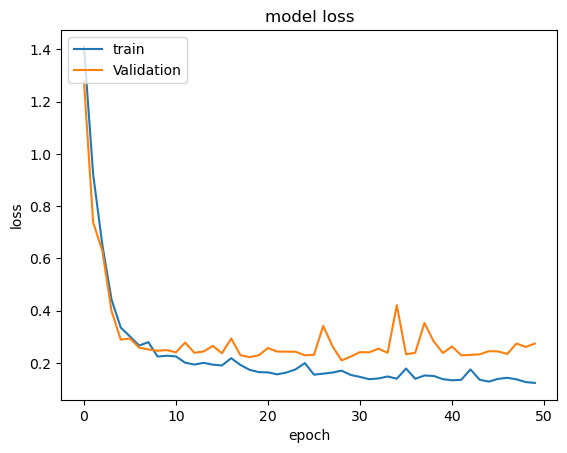

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [70]:
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the GRU model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the GRU model 0.9412962198257446
93/93 [==============================] - 7s 48ms/step


In [71]:
predictions

array([[7.60745315e-05, 1.58284067e-07, 1.30248198e-04, 4.17509722e-03,
        9.95597064e-01, 2.13161129e-05],
       [6.62642924e-05, 1.65173745e-07, 1.11847825e-04, 4.67579626e-03,
        9.95122612e-01, 2.34055497e-05],
       [6.42443629e-05, 1.73071058e-07, 1.06942760e-04, 4.90774820e-03,
        9.94895875e-01, 2.49837722e-05],
       ...,
       [6.73991735e-06, 9.99738872e-01, 2.08299680e-04, 4.84315387e-06,
        1.94470829e-07, 4.10710854e-05],
       [7.43352257e-06, 9.99733508e-01, 2.05992197e-04, 5.37525466e-06,
        2.11169038e-07, 4.74434928e-05],
       [7.66823086e-06, 9.99726951e-01, 2.12166793e-04, 5.36494599e-06,
        2.06828304e-07, 4.75564302e-05]], dtype=float32)

In [72]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[471   1  24   0   0   0]
 [  0 467   1   2   1   0]
 [  0   0 420   0   0   0]
 [  0   0   0 406  85   0]
 [  0   0   0  59 473   0]
 [  0   0   0   0   0 537]]
**** Classification Report ****
              precision    recall  f1-score   support

     Walking       1.00      0.95      0.97       496
      Walkup       1.00      0.99      0.99       471
    Walkdown       0.94      1.00      0.97       420
     Sitting       0.87      0.83      0.85       491
    Standing       0.85      0.89      0.87       532
      Laying       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



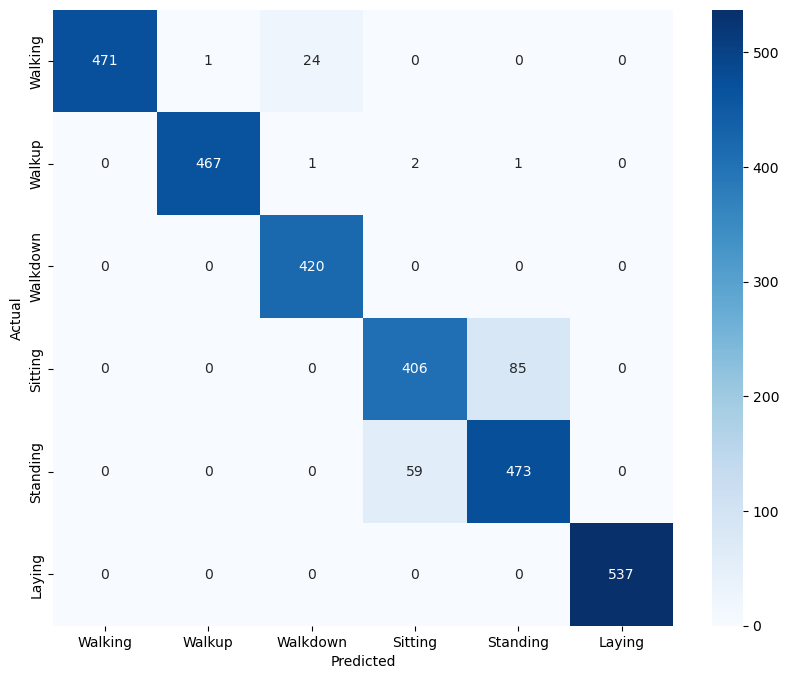

In [73]:
classNames=["Walking","Walkup","Walkdown","Sitting","Standing","Laying"]
display_results(testy,predictions,classNames)